In [5]:
from dummy_helper import DummyModel


In [6]:
model = DummyModel()

In [7]:
def print_param_dtype(model):
    for name, param in model.named_parameters():
        print(f"{name} is loaded in {param.dtype}")

In [8]:
print_param_dtype(model)

token_embedding.weight is loaded in torch.float32
linear_1.weight is loaded in torch.float32
linear_1.bias is loaded in torch.float32
layernorm_1.weight is loaded in torch.float32
layernorm_1.bias is loaded in torch.float32
linear_2.weight is loaded in torch.float32
linear_2.bias is loaded in torch.float32
layernorm_2.weight is loaded in torch.float32
layernorm_2.bias is loaded in torch.float32
head.weight is loaded in torch.float32
head.bias is loaded in torch.float32


In [9]:
# float 16
model_fp16 = DummyModel().half()

In [10]:
print_param_dtype(model_fp16)

token_embedding.weight is loaded in torch.float16
linear_1.weight is loaded in torch.float16
linear_1.bias is loaded in torch.float16
layernorm_1.weight is loaded in torch.float16
layernorm_1.bias is loaded in torch.float16
linear_2.weight is loaded in torch.float16
linear_2.bias is loaded in torch.float16
layernorm_2.weight is loaded in torch.float16
layernorm_2.bias is loaded in torch.float16
head.weight is loaded in torch.float16
head.bias is loaded in torch.float16


In [11]:
model_fp16

DummyModel(
  (token_embedding): Embedding(2, 2)
  (linear_1): Linear(in_features=2, out_features=2, bias=True)
  (layernorm_1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
  (linear_2): Linear(in_features=2, out_features=2, bias=True)
  (layernorm_2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=2, out_features=2, bias=True)
)

In [12]:
import torch

In [13]:
dummy_input = torch.LongTensor([[1, 0], [0, 1]])

In [14]:
logits_fp32 = model(dummy_input)
logits_fp32

tensor([[[-0.6872,  0.7132],
         [-0.6872,  0.7132]],

        [[-0.6872,  0.7132],
         [-0.6872,  0.7132]]], grad_fn=<ViewBackward0>)

In [15]:
try:
    logits_fp16 = model_fp16(dummy_input)
except Exception as error:
    print("\033[91m", type(error).__name__, ": ", error, "\033[0m")

In [16]:
logits_fp16

tensor([[[-0.6870,  0.7134],
         [-0.6870,  0.7134]],

        [[-0.6870,  0.7134],
         [-0.6870,  0.7134]]], dtype=torch.float16, grad_fn=<ViewBackward0>)

In [17]:
from copy import deepcopy
model_bf16 = deepcopy(model)

In [18]:
model_bf16 = model_bf16.to(torch.bfloat16)

In [19]:
print_param_dtype(model_bf16)

token_embedding.weight is loaded in torch.bfloat16
linear_1.weight is loaded in torch.bfloat16
linear_1.bias is loaded in torch.bfloat16
layernorm_1.weight is loaded in torch.bfloat16
layernorm_1.bias is loaded in torch.bfloat16
linear_2.weight is loaded in torch.bfloat16
linear_2.bias is loaded in torch.bfloat16
layernorm_2.weight is loaded in torch.bfloat16
layernorm_2.bias is loaded in torch.bfloat16
head.weight is loaded in torch.bfloat16
head.bias is loaded in torch.bfloat16


In [20]:
logits_bf16 = model_bf16(dummy_input)

In [21]:
mean_diff = torch.abs(logits_bf16 - logits_fp32).mean().item()
max_diff = torch.abs(logits_bf16 - logits_fp32).max().item()

print(f"Mean diff: {mean_diff} | Max diff: {max_diff}")

Mean diff: 0.0009979009628295898 | Max diff: 0.0016907453536987305


In [22]:
from transformers import BlipForConditionalGeneration

In [23]:
model_name = "Salesforce/blip-image-captioning-base"

In [24]:
model = BlipForConditionalGeneration.from_pretrained(model_name)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

c:\Users\Dell\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dell\.cache\huggingface\hub\models--Salesforce--blip-image-captioning-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [25]:
fp32_mem_footprint = model.get_memory_footprint()
print("Footprint of the fp32 model in bytes: ",
      fp32_mem_footprint)
print("Footprint of the fp32 model in MBs: ", 
      fp32_mem_footprint/1e+6)

Footprint of the fp32 model in bytes:  989660400
Footprint of the fp32 model in MBs:  989.6604


In [26]:
model_bf16 = BlipForConditionalGeneration.from_pretrained(
                                               model_name,
                               torch_dtype=torch.bfloat16
)

In [27]:
bf16_mem_footprint = model_bf16.get_memory_footprint()

In [28]:
# Get the relative difference
relative_diff = bf16_mem_footprint / fp32_mem_footprint

print("Footprint of the bf16 model in MBs: ", 
      bf16_mem_footprint/1e+6)
print(f"Relative diff: {relative_diff}")

Footprint of the bf16 model in MBs:  494.832248
Relative diff: 0.5000020693967345


In [29]:
from transformers import BlipProcessor

In [30]:
processor = BlipProcessor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

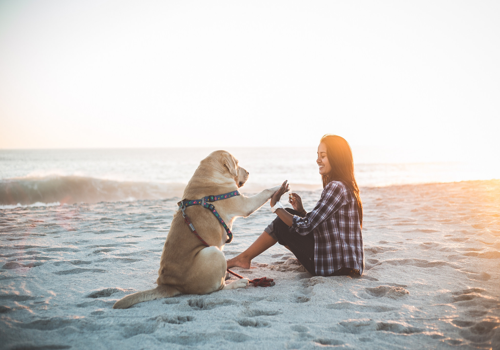

In [32]:
from dummy_helper import load_image, get_generation
from IPython.display import display

img_url = 'https://storage.googleapis.com/\
sfr-vision-language-research/BLIP/demo.jpg'

image = load_image(img_url)
display(image.resize((500, 350)))

In [33]:
results_fp32 = get_generation(model, 
                              processor, 
                              image, 
                              torch.float32)

In [34]:
print("fp32 Model Results:\n", results_fp32)

fp32 Model Results:
 a woman sitting on the beach with her dog


In [36]:
results_bf16 = get_generation(model_bf16, 
                              processor, 
                              image, 
                              torch.bfloat16)

KeyboardInterrupt: 

In [ ]:
print("bf16 Model Results:\n", results_bf16)

# Default Data Type
 - For Hugging Face Transformers library, the deafult data type to load the models in is float32
- You can set the "default data type" as what you want.

In [ ]:
desired_dtype = torch.bfloat16
torch.set_default_dtype(desired_dtype)

In [ ]:
dummy_model_bf16 = DummyModel()

In [ ]:
print_param_dtype(dummy_model_bf16)

 - Similarly, you can reset the default data type to float32.

In [ ]:
torch.set_default_dtype(torch.float32)